In [5]:
!pip freeze > requirements.txt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import numpy as np
import rasterio


ModuleNotFoundError: No module named 'segmentation_models_pytorch'

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_HEIGHT = 352
IMAGE_WIDTH = 352
PIN_MEMORY = True
TRAIN_DIR = os.path.join("dataset", "train")
TEST_DIR = os.path.join("dataset", "test")
BATCH_SIZE = 2

### Dataset

In [ ]:
class SentinelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = []

        # Walk through the root directory (e.g., 'dataset_new/train')
        for date_folder in sorted(os.listdir(root_dir)):
            date_path = os.path.join(root_dir, date_folder)
            if not os.path.isdir(date_path):
                continue

            img_vh_dir = os.path.join(date_path, 'img/vh_decibel')
            img_vv_dir = os.path.join(date_path, 'img/vv_decibel')
            mask_dir = os.path.join(date_path, 'mask')

            # Check if the directories exist and contain files
            if not os.path.isdir(img_vh_dir) or not os.listdir(img_vh_dir):
                print(f"Warning: No VH images found in {img_vh_dir}. Skipping {date_folder}.")
                continue
            if not os.path.isdir(img_vv_dir) or not os.listdir(img_vv_dir):
                print(f"Warning: No VV images found in {img_vv_dir}. Skipping {date_folder}.")
                continue
            if not os.path.isdir(mask_dir) or not os.listdir(mask_dir):
                print(f"Warning: No mask files found in {mask_dir}. Skipping {date_folder}.")
                continue

            for i in range(len(os.listdir(img_vh_dir))):
                img_vh_file = os.path.join(img_vh_dir, os.listdir(img_vh_dir)[i])
                img_vv_file = os.path.join(img_vv_dir, os.listdir(img_vv_dir)[i])
                mask_file = os.path.join(mask_dir, os.listdir(mask_dir)[i])
                self.files.append((img_vh_file, img_vv_file, mask_file))


    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_vh_path, img_vv_path, mask_path = self.files[index]

        # Load VH and VV images using rasterio
        with rasterio.open(img_vh_path) as src:
            img_vh_image = src.read(1).astype(np.float32)
        with rasterio.open(img_vv_path) as src:
            img_vv_image = src.read(1).astype(np.float32)

        # Calculate the ratio (VH/VV) and handle division by zero
        # Add a small epsilon to the denominator to avoid division by zero
        ratio_image = np.divide(img_vv_image, img_vh_image + 1e-8).astype(np.float32)
        # ratio_image = ((img_vh_image + img_vv_image) / 2).astype(np.float32)
        # ratio_image = np.divide(
        #     np.subtract(img_vv_image, img_vh_image),
        #     np.add(img_vv_image, img_vh_image) + 1e-8
        # ).astype(np.float32)


        # Load mask using rasterio and map values from [0, 255] to [0, 1]
        with rasterio.open(mask_path) as src:
            # Load mask as integer type
            mask_image = src.read(1)


        # Stack images to create a 3-channel input (H, W, 3)
        image = np.stack([img_vh_image, img_vv_image, ratio_image], axis=-1)
        mask = np.array(mask_image, dtype = np.float32)

        if self.transform is not None:
            # Apply transform to image and mask
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]


        return image, mask

### DeepLabV3+ UNet

In [ ]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

class DeepLabUNet352_Binary(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = smp.DeepLabV3Plus(
            encoder_name="efficientnet-b4",  # Slightly more capacity
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            decoder_use_batchnorm=True,  # Add BN
            decoder_attention_type="scse",  # Spatial/channel attention
            decoder_dropout=0.1,  # Increased dropout
            activation=None
        )
        # Add spatial regularization
        self.spatial_dropout = nn.Dropout2d(0.3)

    def forward(self, x):
        x = self.model(x)
        return self.spatial_dropout(x)

# Test with your input shape
if __name__ == "__main__":
    model = DeepLabUNet352_Binary()
    dummy_image = torch.randn(2, 3, 352, 352)      # Simulate one RGB image
    output = model(dummy_image)
    print(f"Output shape: {output.shape}")         # Expect [1, 1, 352, 352]


Output shape: torch.Size([2, 1, 352, 352])


### Training Functions

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    total_loss = 0.0  # Initialize total loss for the epoch

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(DEVICE)
        targets = targets.float().to(DEVICE).unsqueeze(1) # Change dtype to long and remove unsqueeze(1)

        # forward
        predictions = model(data)
        loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

        total_loss += loss.item()  # Accumulate loss for the epoch

    avg_loss = total_loss / len(loader)  # Calculate average loss for the epoch
    return avg_loss # Return the average training loss for the epoch

In [ ]:
def check_accuracy(loader, model, loss_fn, device, n_class):
    num_correct = 0
    num_pixels = 0
    total_loss = 0
    num_batches = 0

    # Initialize lists to store per-class metrics
    num_classes = n_class
    class_true_positives = [0] * num_classes
    class_false_positives = [0] * num_classes
    class_false_negatives = [0] * num_classes
    class_intersections = [0] * num_classes
    class_unions = [0] * num_classes
    class_correct_pixels = [0] * num_classes
    class_total_pixels = [0] * num_classes

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).long()
            predictions = model(x).to(device)
            loss = loss_fn(predictions, y).to(device)

            if not torch.isnan(loss):
                total_loss += loss.item()
                num_batches += 1

            preds = torch.argmax(predictions, dim=1)

            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

            # Calculate per-class metrics
            for class_idx in range(num_classes):
                true_positives = ((preds == class_idx) & (y == class_idx)).sum().item()
                false_positives = ((preds == class_idx) & (y != class_idx)).sum().item()
                false_negatives = ((preds != class_idx) & (y == class_idx)).sum().item()
                intersection = true_positives
                union = true_positives + false_positives + false_negatives

                class_true_positives[class_idx] += true_positives
                class_false_positives[class_idx] += false_positives
                class_false_negatives[class_idx] += false_negatives
                class_intersections[class_idx] += intersection
                class_unions[class_idx] += union
                class_correct_pixels[class_idx] += (preds[y == class_idx] == class_idx).sum().item()
                class_total_pixels[class_idx] += (y == class_idx).sum().item()


    accuracy = num_correct / num_pixels * 100 if num_pixels > 0 else float('nan')
    avg_loss = total_loss / num_batches if num_batches > 0 else float('nan')

    # Calculate per-class and averaged metrics
    class_dice_scores = [
        (2 * class_intersections[i]) / (class_true_positives[i] + class_false_positives[i] + class_true_positives[i] + class_false_negatives[i] + 1e-8) if (class_true_positives[i] + class_false_positives[i] + class_true_positives[i] + class_false_negatives[i]) > 0 else float('nan')
        for i in range(num_classes)
    ]
    class_iou_scores = [
        class_intersections[i] / (class_unions[i] + 1e-8) if class_unions[i] > 0 else float('nan')
        for i in range(num_classes)
    ]
    class_precisions = [
        class_true_positives[i] / (class_true_positives[i] + class_false_positives[i] + 1e-8) if (class_true_positives[i] + class_false_positives[i]) > 0 else float('nan')
        for i in range(num_classes)
    ]
    class_recalls = [
        class_true_positives[i] / (class_true_positives[i] + class_false_negatives[i] + 1e-8) if (class_true_positives[i] + class_false_negatives[i]) > 0 else float('nan')
        for i in range(num_classes)
    ]
    class_f1_scores = [
        2 * (class_precisions[i] * class_recalls[i]) / (class_precisions[i] + class_recalls[i] + 1e-8) if (class_precisions[i] + class_recalls[i]) > 0 else float('nan')
        for i in range(num_classes)
    ]
    class_accuracies = [
        class_correct_pixels[i] / (class_total_pixels[i] + 1e-8) * 100 if class_total_pixels[i] > 0 else float('nan')
        for i in range(num_classes)
    ]


    print(f"Overall Accuracy: {accuracy:.2f}")
    print(f"Average Validation Loss: {avg_loss:.4f}")

    # Print per-class metrics
    for i in range(num_classes):
        print(f"Class {i} - Accuracy: {class_accuracies[i]:.2f}, Dice: {class_dice_scores[i]:.4f}, IoU: {class_iou_scores[i]:.4f}, Precision: {class_precisions[i]:.4f}, Recall: {class_recalls[i]:.4f}, F1 Score: {class_f1_scores[i]:.4f}")


    model.train()
    # Return per-class metrics and overall loss
    return class_accuracies, class_dice_scores, class_iou_scores, avg_loss, class_precisions, class_recalls, class_f1_scores

### Check Accuracy


In [ ]:
def check_accuracy(loader, model, loss_fn, device):
    num_correct = 0
    num_pixels = 0
    total_loss = 0
    num_batches = 0

    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).float().unsqueeze(1)  # Expecting shape [B, 1, H, W]

            predictions = model(x)
            loss = loss_fn(predictions, y)

            if not torch.isnan(loss):
                total_loss += loss.item()
                num_batches += 1

            # Convert logits -> probabilities -> binary mask
            probs = torch.sigmoid(predictions)
            preds = (probs > 0.47).float()

            # Count correct
            num_correct += (preds == y).sum().item()
            num_pixels += torch.numel(preds)

            # Compute TP, FP, FN, TN
            true_positives += ((preds == 1) & (y == 1)).sum().item()
            false_positives += ((preds == 1) & (y == 0)).sum().item()
            false_negatives += ((preds == 0) & (y == 1)).sum().item()
            true_negatives += ((preds == 0) & (y == 0)).sum().item()

    accuracy = num_correct / num_pixels * 100 if num_pixels > 0 else float('nan')
    avg_loss = total_loss / num_batches if num_batches > 0 else float('nan')

    intersection = true_positives
    union = true_positives + false_positives + false_negatives
    dice = (2 * intersection) / (2 * intersection + false_positives + false_negatives + 1e-8)
    iou = intersection / (union + 1e-8)
    precision = true_positives / (true_positives + false_positives + 1e-8)
    recall = true_positives / (true_positives + false_negatives + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    print(f"Overall Accuracy: {accuracy:.2f}")
    print(f"Average Validation Loss: {avg_loss:.4f}")
    print(f"Dice: {dice:.4f}, IoU: {iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print("Preds sum:", preds.sum().item())
    print("Targets sum:", y.sum().item())
    print("Batch accuracy:", (preds == y).float().mean().item())
    print("Pred max/min:", predictions.max().item(), predictions.min().item())

    # best_thesh, best_score = find_best_threshold(y.cpu().numpy(), probs.cpu().numpy())
    # print(f"Best threshold: {best_thesh}, Best score: {best_score}")


    model.train()

    return accuracy, avg_loss, dice, iou, precision, recall, f1


### Loader

In [ ]:
train_transform = A.Compose(
    [
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RandomBrightnessContrast(p=0.2), # Add brightness/contrast changes
        A.RandomBrightnessContrast(p=0.3),
        A.GaussNoise(p=0.2),
        A.CoarseDropout(
            max_holes=8,
            max_height=32,
            max_width=32,
            fill_value=0,
            p=0.5
        ),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        ToTensorV2(),
    ],
)


train_ds = SentinelDataset(
    root_dir=TRAIN_DIR,
    transform=train_transform,
)

val_ds = SentinelDataset(
    root_dir=TEST_DIR,
    transform=val_transforms,
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE, # Use the BATCH_SIZE from the config
    num_workers=0,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=0,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

/tmp/ipython-input-291700291.py:13: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


### Training

In [ ]:
LEARNING_RATE = 3e-4
NUM_EPOCHS = 100
WEIGHT_DECAY = 1e-5

model = DeepLabUNet352_Binary().to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) # Add weight_decay
scaler = torch.amp.GradScaler(init_scale=2.**10) # Updated GradScaler initialization
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)


focal_loss = smp.losses.FocalLoss(mode='binary', gamma=2.0, alpha=0.6).to(DEVICE)
tversky_loss = smp.losses.TverskyLoss(mode='binary', alpha=0.4, beta=0.6)  # Penalize FNs more

def combined_loss_fn(predictions, targets, weight = 0.4):
    return (1 - weight) * focal_loss(predictions, targets) + weight * tversky_loss(predictions, targets)

loss_fn = combined_loss_fn


train_losses = []
val_accuracies = []
val_dice_scores = []
val_iou_scores = []
val_losses = []
val_precisions = []
val_recalls = []
val_f1_scores = []

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)
    train_losses.append(train_loss)

    acc, val_loss, dice, iou, prec, rec, f1 = check_accuracy(val_loader, model, loss_fn, DEVICE)

    val_accuracies.append(acc)
    val_dice_scores.append(dice)
    val_iou_scores.append(iou)
    val_losses.append(val_loss)
    val_precisions.append(prec)
    val_recalls.append(rec)
    val_f1_scores.append(f1)

    scheduler.step(val_loss)

torch.save(model.state_dict(), "model.pth")

Epoch 1/100


100%|██████████| 135/135 [00:15<00:00,  8.92it/s, loss=0.335]


Overall Accuracy: 55.45
Average Validation Loss: 0.3385
Dice: 0.2218, IoU: 0.1248, Precision: 0.1524, Recall: 0.4074, F1 Score: 0.2218
Preds sum: 49867.0
Targets sum: 14825.0
Batch accuracy: 0.5639204382896423
Pred max/min: 0.4838901460170746 -1.620078206062317
Epoch 2/100


100%|██████████| 135/135 [00:15<00:00,  8.92it/s, loss=0.341]


Overall Accuracy: 62.13
Average Validation Loss: 0.3373
Dice: 0.2503, IoU: 0.1431, Precision: 0.1810, Recall: 0.4057, F1 Score: 0.2503
Preds sum: 42747.0
Targets sum: 14825.0
Batch accuracy: 0.5974786877632141
Pred max/min: 0.2415335476398468 -3.168060779571533
Epoch 3/100


100%|██████████| 135/135 [00:15<00:00,  8.98it/s, loss=0.332]


Overall Accuracy: 58.86
Average Validation Loss: 0.3374
Dice: 0.2544, IoU: 0.1457, Precision: 0.1772, Recall: 0.4503, F1 Score: 0.2544
Preds sum: 69887.0
Targets sum: 14825.0
Batch accuracy: 0.4549005627632141
Pred max/min: 0.1276596337556839 -3.2429656982421875
Epoch 4/100


100%|██████████| 135/135 [00:14<00:00,  9.01it/s, loss=0.329]


Overall Accuracy: 54.31
Average Validation Loss: 0.3359
Dice: 0.2754, IoU: 0.1597, Precision: 0.1829, Recall: 0.5573, F1 Score: 0.2754
Preds sum: 69216.0
Targets sum: 14825.0
Batch accuracy: 0.44354498386383057
Pred max/min: 0.1582573801279068 -2.885692834854126
Epoch 5/100


100%|██████████| 135/135 [00:14<00:00,  9.02it/s, loss=0.346]


Overall Accuracy: 54.04
Average Validation Loss: 0.3350
Dice: 0.2960, IoU: 0.1737, Precision: 0.1944, Recall: 0.6200, F1 Score: 0.2960
Preds sum: 70946.0
Targets sum: 14825.0
Batch accuracy: 0.45452120900154114
Pred max/min: 0.2640747129917145 -2.7416093349456787
Epoch 6/100


100%|██████████| 135/135 [00:14<00:00,  9.07it/s, loss=0.324]


Overall Accuracy: 37.92
Average Validation Loss: 0.3354
Dice: 0.2862, IoU: 0.1670, Precision: 0.1743, Recall: 0.7984, F1 Score: 0.2862
Preds sum: 92116.0
Targets sum: 14825.0
Batch accuracy: 0.3175280690193176
Pred max/min: 0.21376822888851166 -2.6767117977142334
Epoch 7/100


100%|██████████| 135/135 [00:14<00:00,  9.10it/s, loss=0.344]


Overall Accuracy: 55.35
Average Validation Loss: 0.3330
Dice: 0.3035, IoU: 0.1789, Precision: 0.2005, Recall: 0.6240, F1 Score: 0.3035
Preds sum: 70089.0
Targets sum: 14825.0
Batch accuracy: 0.45509424805641174
Pred max/min: 0.28036507964134216 -2.934391975402832
Epoch 8/100


100%|██████████| 135/135 [00:15<00:00,  9.00it/s, loss=0.354]


Overall Accuracy: 53.30
Average Validation Loss: 0.3322
Dice: 0.3035, IoU: 0.1789, Precision: 0.1977, Recall: 0.6530, F1 Score: 0.3035
Preds sum: 73179.0
Targets sum: 14825.0
Batch accuracy: 0.44720104336738586
Pred max/min: 0.3149409592151642 -2.770026445388794
Epoch 9/100


100%|██████████| 135/135 [00:14<00:00,  9.00it/s, loss=0.36]


Overall Accuracy: 47.70
Average Validation Loss: 0.3339
Dice: 0.2964, IoU: 0.1740, Precision: 0.1875, Recall: 0.7069, F1 Score: 0.2964
Preds sum: 78055.0
Targets sum: 14825.0
Batch accuracy: 0.41680654883384705
Pred max/min: 0.3016090989112854 -2.1111183166503906
Epoch 10/100


100%|██████████| 135/135 [00:15<00:00,  8.96it/s, loss=0.34]


Overall Accuracy: 66.76
Average Validation Loss: 0.3328
Dice: 0.2942, IoU: 0.1725, Precision: 0.2199, Recall: 0.4446, F1 Score: 0.2942
Preds sum: 47173.0
Targets sum: 14825.0
Batch accuracy: 0.5838068127632141
Pred max/min: 0.28447386622428894 -2.0367019176483154
Epoch 11/100


100%|██████████| 135/135 [00:15<00:00,  8.70it/s, loss=0.307]


Overall Accuracy: 57.99
Average Validation Loss: 0.3317
Dice: 0.3135, IoU: 0.1859, Precision: 0.2103, Recall: 0.6154, F1 Score: 0.3135
Preds sum: 64707.0
Targets sum: 14825.0
Batch accuracy: 0.4719621539115906
Pred max/min: 0.32879942655563354 -3.122483491897583
Epoch 12/100


100%|██████████| 135/135 [00:15<00:00,  8.89it/s, loss=0.341]


Overall Accuracy: 47.20
Average Validation Loss: 0.3341
Dice: 0.2871, IoU: 0.1676, Precision: 0.1818, Recall: 0.6821, F1 Score: 0.2871
Preds sum: 86911.0
Targets sum: 14825.0
Batch accuracy: 0.3588745892047882
Pred max/min: 0.08858341723680496 -2.9951517581939697
Epoch 13/100


100%|██████████| 135/135 [00:15<00:00,  8.94it/s, loss=0.331]


Overall Accuracy: 58.54
Average Validation Loss: 0.3308
Dice: 0.3090, IoU: 0.1827, Precision: 0.2087, Recall: 0.5949, F1 Score: 0.3090
Preds sum: 65883.0
Targets sum: 14825.0
Batch accuracy: 0.4714617431163788
Pred max/min: 0.27420511841773987 -2.358093500137329
Epoch 14/100


100%|██████████| 135/135 [00:15<00:00,  8.78it/s, loss=0.3]


Overall Accuracy: 50.57
Average Validation Loss: 0.3331
Dice: 0.2991, IoU: 0.1758, Precision: 0.1920, Recall: 0.6767, F1 Score: 0.2991
Preds sum: 70498.0
Targets sum: 14825.0
Batch accuracy: 0.45293936133384705
Pred max/min: 0.18563981354236603 -1.9305096864700317
Epoch 15/100


100%|██████████| 135/135 [00:15<00:00,  8.74it/s, loss=0.347]


Overall Accuracy: 65.64
Average Validation Loss: 0.3306
Dice: 0.3197, IoU: 0.1903, Precision: 0.2312, Recall: 0.5181, F1 Score: 0.3197
Preds sum: 44509.0
Targets sum: 14825.0
Batch accuracy: 0.5641463994979858
Pred max/min: 0.31948456168174744 -1.8154186010360718
Epoch 16/100


100%|██████████| 135/135 [00:15<00:00,  8.85it/s, loss=0.36]


Overall Accuracy: 62.68
Average Validation Loss: 0.3311
Dice: 0.3043, IoU: 0.1794, Precision: 0.2144, Recall: 0.5236, F1 Score: 0.3043
Preds sum: 61936.0
Targets sum: 14825.0
Batch accuracy: 0.48058977723121643
Pred max/min: 0.3163391351699829 -1.8421518802642822
Epoch 17/100


100%|██████████| 135/135 [00:15<00:00,  8.89it/s, loss=0.338]


Overall Accuracy: 59.27
Average Validation Loss: 0.3301
Dice: 0.3221, IoU: 0.1919, Precision: 0.2174, Recall: 0.6209, F1 Score: 0.3221
Preds sum: 63456.0
Targets sum: 14825.0
Batch accuracy: 0.47955673933029175
Pred max/min: 0.3197191655635834 -2.0186822414398193
Epoch 18/100


100%|██████████| 135/135 [00:15<00:00,  8.93it/s, loss=0.349]


Overall Accuracy: 44.85
Average Validation Loss: 0.3323
Dice: 0.3070, IoU: 0.1813, Precision: 0.1909, Recall: 0.7837, F1 Score: 0.3070
Preds sum: 91030.0
Targets sum: 14825.0
Batch accuracy: 0.3214343190193176
Pred max/min: 0.5112419128417969 -2.1759531497955322
Epoch 19/100


100%|██████████| 135/135 [00:15<00:00,  8.85it/s, loss=0.339]


Overall Accuracy: 49.78
Average Validation Loss: 0.3309
Dice: 0.3140, IoU: 0.1862, Precision: 0.1994, Recall: 0.7374, F1 Score: 0.3140
Preds sum: 84054.0
Targets sum: 14825.0
Batch accuracy: 0.33988410234451294
Pred max/min: 0.3973822593688965 -2.3623130321502686
Epoch 20/100


100%|██████████| 135/135 [00:15<00:00,  8.79it/s, loss=0.366]


Overall Accuracy: 53.61
Average Validation Loss: 0.3321
Dice: 0.3067, IoU: 0.1811, Precision: 0.1999, Recall: 0.6584, F1 Score: 0.3067
Preds sum: 59717.0
Targets sum: 14825.0
Batch accuracy: 0.4840037226676941
Pred max/min: 0.588230311870575 -2.024386405944824
Epoch 21/100


100%|██████████| 135/135 [00:15<00:00,  8.88it/s, loss=0.345]


Overall Accuracy: 57.55
Average Validation Loss: 0.3295
Dice: 0.3112, IoU: 0.1843, Precision: 0.2083, Recall: 0.6154, F1 Score: 0.3112
Preds sum: 50230.0
Targets sum: 14825.0
Batch accuracy: 0.5418307781219482
Pred max/min: 0.5814807415008545 -2.254326343536377
Epoch 22/100


100%|██████████| 135/135 [00:15<00:00,  8.84it/s, loss=0.329]


Overall Accuracy: 73.53
Average Validation Loss: 0.3400
Dice: 0.2952, IoU: 0.1732, Precision: 0.2523, Recall: 0.3557, F1 Score: 0.2952
Preds sum: 34468.0
Targets sum: 14825.0
Batch accuracy: 0.6259442567825317
Pred max/min: 0.3005940020084381 -2.562206983566284
Epoch 23/100


100%|██████████| 135/135 [00:15<00:00,  8.91it/s, loss=0.325]


Overall Accuracy: 58.41
Average Validation Loss: 0.3355
Dice: 0.3055, IoU: 0.1803, Precision: 0.2065, Recall: 0.5868, F1 Score: 0.3055
Preds sum: 68085.0
Targets sum: 14825.0
Batch accuracy: 0.4664255976676941
Pred max/min: 0.09345781803131104 -1.7318048477172852
Epoch 24/100


100%|██████████| 135/135 [00:15<00:00,  8.84it/s, loss=0.32]


Overall Accuracy: 57.90
Average Validation Loss: 0.3303
Dice: 0.3143, IoU: 0.1864, Precision: 0.2106, Recall: 0.6189, F1 Score: 0.3143
Preds sum: 62600.0
Targets sum: 14825.0
Batch accuracy: 0.501815915107727
Pred max/min: 0.28769025206565857 -3.0502614974975586
Epoch 25/100


100%|██████████| 135/135 [00:15<00:00,  8.93it/s, loss=0.328]


Overall Accuracy: 76.58
Average Validation Loss: 0.3295
Dice: 0.3222, IoU: 0.1921, Precision: 0.2935, Recall: 0.3572, F1 Score: 0.3222
Preds sum: 35826.0
Targets sum: 14825.0
Batch accuracy: 0.6616008877754211
Pred max/min: 0.07828506082296371 -1.7486093044281006
Epoch 26/100


100%|██████████| 135/135 [00:15<00:00,  8.88it/s, loss=0.323]


Overall Accuracy: 66.85
Average Validation Loss: 0.3292
Dice: 0.3230, IoU: 0.1926, Precision: 0.2369, Recall: 0.5074, F1 Score: 0.3230
Preds sum: 46267.0
Targets sum: 14825.0
Batch accuracy: 0.6035801768302917
Pred max/min: 0.3447781503200531 -2.3782474994659424
Epoch 27/100


100%|██████████| 135/135 [00:15<00:00,  8.83it/s, loss=0.338]


Overall Accuracy: 57.71
Average Validation Loss: 0.3321
Dice: 0.2972, IoU: 0.1746, Precision: 0.2006, Recall: 0.5738, F1 Score: 0.2972
Preds sum: 61287.0
Targets sum: 14825.0
Batch accuracy: 0.5204674601554871
Pred max/min: 0.29733920097351074 -1.9461907148361206
Epoch 28/100


100%|██████████| 135/135 [00:15<00:00,  8.80it/s, loss=0.329]


Overall Accuracy: 63.82
Average Validation Loss: 0.3272
Dice: 0.3304, IoU: 0.1979, Precision: 0.2322, Recall: 0.5728, F1 Score: 0.3304
Preds sum: 48353.0
Targets sum: 14825.0
Batch accuracy: 0.5877776145935059
Pred max/min: 0.24677219986915588 -2.1091785430908203
Epoch 29/100


100%|██████████| 135/135 [00:15<00:00,  8.83it/s, loss=0.303]


Overall Accuracy: 67.48
Average Validation Loss: 0.3273
Dice: 0.3186, IoU: 0.1895, Precision: 0.2365, Recall: 0.4878, F1 Score: 0.3186
Preds sum: 36176.0
Targets sum: 14825.0
Batch accuracy: 0.6372917294502258
Pred max/min: 0.29603108763694763 -2.7638187408447266
Epoch 30/100


100%|██████████| 135/135 [00:15<00:00,  8.82it/s, loss=0.303]


Overall Accuracy: 50.55
Average Validation Loss: 0.3311
Dice: 0.3033, IoU: 0.1787, Precision: 0.1943, Recall: 0.6906, F1 Score: 0.3033
Preds sum: 71393.0
Targets sum: 14825.0
Batch accuracy: 0.46363312005996704
Pred max/min: 0.3245377540588379 -2.6335160732269287
Epoch 31/100


100%|██████████| 135/135 [00:15<00:00,  8.71it/s, loss=0.351]


Overall Accuracy: 52.03
Average Validation Loss: 0.3407
Dice: 0.2906, IoU: 0.1700, Precision: 0.1888, Recall: 0.6306, F1 Score: 0.2906
Preds sum: 76157.0
Targets sum: 14825.0
Batch accuracy: 0.4214552938938141
Pred max/min: -0.008782252669334412 -1.571758508682251
Epoch 32/100


100%|██████████| 135/135 [00:15<00:00,  8.89it/s, loss=0.328]


Overall Accuracy: 69.42
Average Validation Loss: 0.3293
Dice: 0.3263, IoU: 0.1950, Precision: 0.2485, Recall: 0.4752, F1 Score: 0.3263
Preds sum: 33503.0
Targets sum: 14825.0
Batch accuracy: 0.6517949104309082
Pred max/min: 0.09216145426034927 -2.015322685241699
Epoch 33/100


100%|██████████| 135/135 [00:15<00:00,  8.78it/s, loss=0.32]


Overall Accuracy: 78.98
Average Validation Loss: 0.3309
Dice: 0.2620, IoU: 0.1507, Precision: 0.2893, Recall: 0.2394, F1 Score: 0.2620
Preds sum: 10242.0
Targets sum: 14825.0
Batch accuracy: 0.8022742867469788
Pred max/min: -0.017672143876552582 -2.0013861656188965
Epoch 34/100


100%|██████████| 135/135 [00:15<00:00,  8.89it/s, loss=0.349]


Overall Accuracy: 67.29
Average Validation Loss: 0.3240
Dice: 0.3508, IoU: 0.2127, Precision: 0.2540, Recall: 0.5671, F1 Score: 0.3508
Preds sum: 37624.0
Targets sum: 14825.0
Batch accuracy: 0.6198750138282776
Pred max/min: 0.2986810803413391 -1.7463228702545166
Epoch 35/100


100%|██████████| 135/135 [00:15<00:00,  8.88it/s, loss=0.325]


Overall Accuracy: 61.27
Average Validation Loss: 0.3275
Dice: 0.3194, IoU: 0.1900, Precision: 0.2199, Recall: 0.5831, F1 Score: 0.3194
Preds sum: 52694.0
Targets sum: 14825.0
Batch accuracy: 0.5572459101676941
Pred max/min: 0.22644950449466705 -1.7936251163482666
Epoch 36/100


100%|██████████| 135/135 [00:15<00:00,  8.90it/s, loss=0.328]


Overall Accuracy: 57.70
Average Validation Loss: 0.3274
Dice: 0.3179, IoU: 0.1890, Precision: 0.2123, Recall: 0.6324, F1 Score: 0.3179
Preds sum: 38469.0
Targets sum: 14825.0
Batch accuracy: 0.627405047416687
Pred max/min: 0.18345095217227936 -1.817116141319275
Epoch 37/100


100%|██████████| 135/135 [00:15<00:00,  8.89it/s, loss=0.34]


Overall Accuracy: 66.31
Average Validation Loss: 0.3339
Dice: 0.3126, IoU: 0.1853, Precision: 0.2292, Recall: 0.4915, F1 Score: 0.3126
Preds sum: 53628.0
Targets sum: 14825.0
Batch accuracy: 0.5848479270935059
Pred max/min: 0.21525782346725464 -4.696911334991455
Epoch 38/100


100%|██████████| 135/135 [00:15<00:00,  8.89it/s, loss=0.306]


Overall Accuracy: 64.63
Average Validation Loss: 0.3235
Dice: 0.3462, IoU: 0.2093, Precision: 0.2432, Recall: 0.6009, F1 Score: 0.3462
Preds sum: 56656.0
Targets sum: 14825.0
Batch accuracy: 0.5575687289237976
Pred max/min: 0.19891099631786346 -1.9065847396850586
Epoch 39/100


100%|██████████| 135/135 [00:15<00:00,  8.95it/s, loss=0.381]


Overall Accuracy: 59.93
Average Validation Loss: 0.3289
Dice: 0.3229, IoU: 0.1926, Precision: 0.2192, Recall: 0.6131, F1 Score: 0.3229
Preds sum: 77285.0
Targets sum: 14825.0
Batch accuracy: 0.4292355179786682
Pred max/min: 0.33747655153274536 -3.5580663681030273
Epoch 40/100


100%|██████████| 135/135 [00:15<00:00,  8.85it/s, loss=0.311]


Overall Accuracy: 54.93
Average Validation Loss: 0.3421
Dice: 0.3094, IoU: 0.1830, Precision: 0.2032, Recall: 0.6478, F1 Score: 0.3094
Preds sum: 62621.0
Targets sum: 14825.0
Batch accuracy: 0.4929945468902588
Pred max/min: 1.3411897420883179 -2.173698663711548
Epoch 41/100


100%|██████████| 135/135 [00:15<00:00,  8.91it/s, loss=0.36]


Overall Accuracy: 54.78
Average Validation Loss: 0.3238
Dice: 0.3219, IoU: 0.1918, Precision: 0.2100, Recall: 0.6888, F1 Score: 0.3219
Preds sum: 79473.0
Targets sum: 14825.0
Batch accuracy: 0.4131585657596588
Pred max/min: 0.26429179310798645 -2.1099231243133545
Epoch 42/100


100%|██████████| 135/135 [00:15<00:00,  8.93it/s, loss=0.309]


Overall Accuracy: 72.52
Average Validation Loss: 0.3321
Dice: 0.3026, IoU: 0.1782, Precision: 0.2503, Recall: 0.3824, F1 Score: 0.3026
Preds sum: 52011.0
Targets sum: 14825.0
Batch accuracy: 0.580723762512207
Pred max/min: 0.32713404297828674 -6.314901351928711
Epoch 43/100


100%|██████████| 135/135 [00:15<00:00,  8.95it/s, loss=0.348]


Overall Accuracy: 68.58
Average Validation Loss: 0.3232
Dice: 0.3492, IoU: 0.2115, Precision: 0.2578, Recall: 0.5408, F1 Score: 0.3492
Preds sum: 37412.0
Targets sum: 14825.0
Batch accuracy: 0.6496723294258118
Pred max/min: 0.497870534658432 -4.995311737060547
Epoch 44/100


100%|██████████| 135/135 [00:15<00:00,  8.90it/s, loss=0.377]


Overall Accuracy: 46.36
Average Validation Loss: 0.3279
Dice: 0.3209, IoU: 0.1911, Precision: 0.1999, Recall: 0.8132, F1 Score: 0.3209
Preds sum: 90718.0
Targets sum: 14825.0
Batch accuracy: 0.3404006063938141
Pred max/min: 0.2657039761543274 -2.506662607192993
Epoch 45/100


100%|██████████| 135/135 [00:15<00:00,  8.85it/s, loss=0.329]


Overall Accuracy: 49.72
Average Validation Loss: 0.3260
Dice: 0.3192, IoU: 0.1899, Precision: 0.2023, Recall: 0.7564, F1 Score: 0.3192
Preds sum: 71261.0
Targets sum: 14825.0
Batch accuracy: 0.4724302589893341
Pred max/min: 0.3866276144981384 -3.9726736545562744
Epoch 46/100


100%|██████████| 135/135 [00:15<00:00,  8.89it/s, loss=0.323]


Overall Accuracy: 69.14
Average Validation Loss: 0.3282
Dice: 0.3345, IoU: 0.2009, Precision: 0.2519, Recall: 0.4977, F1 Score: 0.3345
Preds sum: 36986.0
Targets sum: 14825.0
Batch accuracy: 0.6149518489837646
Pred max/min: 0.7394632697105408 -3.5372729301452637
Epoch 47/100


100%|██████████| 135/135 [00:15<00:00,  8.84it/s, loss=0.305]


Overall Accuracy: 65.45
Average Validation Loss: 0.3336
Dice: 0.3252, IoU: 0.1942, Precision: 0.2338, Recall: 0.5342, F1 Score: 0.3252
Preds sum: 41265.0
Targets sum: 14825.0
Batch accuracy: 0.5901020169258118
Pred max/min: 0.8446450233459473 -2.802239418029785
Epoch 48/100


100%|██████████| 135/135 [00:15<00:00,  8.89it/s, loss=0.332]


Overall Accuracy: 71.24
Average Validation Loss: 0.3246
Dice: 0.3653, IoU: 0.2235, Precision: 0.2784, Recall: 0.5311, F1 Score: 0.3653
Preds sum: 34544.0
Targets sum: 14825.0
Batch accuracy: 0.6350642442703247
Pred max/min: 0.2086644172668457 -1.7821886539459229
Epoch 49/100


100%|██████████| 135/135 [00:15<00:00,  8.82it/s, loss=0.317]


Overall Accuracy: 72.20
Average Validation Loss: 0.3311
Dice: 0.3513, IoU: 0.2131, Precision: 0.2760, Recall: 0.4831, F1 Score: 0.3513
Preds sum: 29972.0
Targets sum: 14825.0
Batch accuracy: 0.6613587737083435
Pred max/min: 0.32331398129463196 -1.996993899345398
Epoch 50/100


100%|██████████| 135/135 [00:15<00:00,  8.92it/s, loss=0.348]


Overall Accuracy: 71.61
Average Validation Loss: 0.3293
Dice: 0.3338, IoU: 0.2004, Precision: 0.2631, Recall: 0.4565, F1 Score: 0.3338
Preds sum: 24157.0
Targets sum: 14825.0
Batch accuracy: 0.7003324627876282
Pred max/min: 0.14111042022705078 -2.58432674407959
Epoch 51/100


100%|██████████| 135/135 [00:15<00:00,  8.67it/s, loss=0.354]


Overall Accuracy: 63.22
Average Validation Loss: 0.3242
Dice: 0.3414, IoU: 0.2058, Precision: 0.2368, Recall: 0.6116, F1 Score: 0.3414
Preds sum: 58202.0
Targets sum: 14825.0
Batch accuracy: 0.5361005067825317
Pred max/min: 0.33611011505126953 -2.085836172103882
Epoch 52/100


100%|██████████| 135/135 [00:15<00:00,  8.90it/s, loss=0.348]


Overall Accuracy: 61.34
Average Validation Loss: 0.3469
Dice: 0.3111, IoU: 0.1842, Precision: 0.2154, Recall: 0.5601, F1 Score: 0.3111
Preds sum: 58575.0
Targets sum: 14825.0
Batch accuracy: 0.5189824104309082
Pred max/min: 0.4733201265335083 -2.213775396347046
Epoch 53/100


100%|██████████| 135/135 [00:15<00:00,  8.90it/s, loss=0.31]


Overall Accuracy: 67.96
Average Validation Loss: 0.3209
Dice: 0.3482, IoU: 0.2108, Precision: 0.2549, Recall: 0.5492, F1 Score: 0.3482
Preds sum: 47316.0
Targets sum: 14825.0
Batch accuracy: 0.5644773244857788
Pred max/min: 0.5916752219200134 -1.7515491247177124
Epoch 54/100


100%|██████████| 135/135 [00:15<00:00,  8.90it/s, loss=0.314]


Overall Accuracy: 61.24
Average Validation Loss: 0.3253
Dice: 0.3498, IoU: 0.2120, Precision: 0.2368, Recall: 0.6690, F1 Score: 0.3498
Preds sum: 55878.0
Targets sum: 14825.0
Batch accuracy: 0.5560675859451294
Pred max/min: 0.08086320757865906 -2.20731258392334
Epoch 55/100


100%|██████████| 135/135 [00:15<00:00,  8.86it/s, loss=0.36]


Overall Accuracy: 70.46
Average Validation Loss: 0.3232
Dice: 0.3454, IoU: 0.2088, Precision: 0.2638, Recall: 0.5001, F1 Score: 0.3454
Preds sum: 37499.0
Targets sum: 14825.0
Batch accuracy: 0.6237570643424988
Pred max/min: 0.5376778244972229 -1.9250625371932983
Epoch 56/100


100%|██████████| 135/135 [00:15<00:00,  8.89it/s, loss=0.371]


Overall Accuracy: 61.72
Average Validation Loss: 0.3263
Dice: 0.3383, IoU: 0.2036, Precision: 0.2315, Recall: 0.6280, F1 Score: 0.3383
Preds sum: 50109.0
Targets sum: 14825.0
Batch accuracy: 0.5818697810173035
Pred max/min: 0.21732281148433685 -2.5972418785095215
Epoch 57/100


100%|██████████| 135/135 [00:15<00:00,  8.88it/s, loss=0.283]


Overall Accuracy: 58.41
Average Validation Loss: 0.3243
Dice: 0.3379, IoU: 0.2033, Precision: 0.2247, Recall: 0.6811, F1 Score: 0.3379
Preds sum: 56688.0
Targets sum: 14825.0
Batch accuracy: 0.5237199664115906
Pred max/min: 0.34460994601249695 -2.0903656482696533
Epoch 58/100


100%|██████████| 135/135 [00:15<00:00,  8.87it/s, loss=0.349]


Overall Accuracy: 70.69
Average Validation Loss: 0.3262
Dice: 0.3460, IoU: 0.2092, Precision: 0.2652, Recall: 0.4976, F1 Score: 0.3460
Preds sum: 46203.0
Targets sum: 14825.0
Batch accuracy: 0.59765625
Pred max/min: 0.5423244833946228 -1.7976491451263428
Epoch 59/100


100%|██████████| 135/135 [00:15<00:00,  8.88it/s, loss=0.296]


Overall Accuracy: 69.74
Average Validation Loss: 0.3270
Dice: 0.3543, IoU: 0.2153, Precision: 0.2654, Recall: 0.5327, F1 Score: 0.3543
Preds sum: 39264.0
Targets sum: 14825.0
Batch accuracy: 0.630625307559967
Pred max/min: 0.557918906211853 -2.7666046619415283
Epoch 60/100


100%|██████████| 135/135 [00:15<00:00,  8.88it/s, loss=0.307]


Overall Accuracy: 58.21
Average Validation Loss: 0.3275
Dice: 0.3241, IoU: 0.1934, Precision: 0.2167, Recall: 0.6429, F1 Score: 0.3241
Preds sum: 67980.0
Targets sum: 14825.0
Batch accuracy: 0.47414931654930115
Pred max/min: 0.5184703469276428 -1.7151691913604736
Epoch 61/100


100%|██████████| 135/135 [00:15<00:00,  8.91it/s, loss=0.314]


Overall Accuracy: 71.03
Average Validation Loss: 0.3246
Dice: 0.3384, IoU: 0.2036, Precision: 0.2627, Recall: 0.4753, F1 Score: 0.3384
Preds sum: 38128.0
Targets sum: 14825.0
Batch accuracy: 0.6114975810050964
Pred max/min: 0.44935381412506104 -2.5307836532592773
Epoch 62/100


100%|██████████| 135/135 [00:15<00:00,  8.92it/s, loss=0.319]


Overall Accuracy: 69.37
Average Validation Loss: 0.3407
Dice: 0.3391, IoU: 0.2042, Precision: 0.2555, Recall: 0.5042, F1 Score: 0.3391
Preds sum: 41233.0
Targets sum: 14825.0
Batch accuracy: 0.6076316833496094
Pred max/min: 0.25002431869506836 -3.5322062969207764
Epoch 63/100


100%|██████████| 135/135 [00:15<00:00,  8.85it/s, loss=0.315]


Overall Accuracy: 65.91
Average Validation Loss: 0.3197
Dice: 0.3609, IoU: 0.2202, Precision: 0.2549, Recall: 0.6175, F1 Score: 0.3609
Preds sum: 45418.0
Targets sum: 14825.0
Batch accuracy: 0.5798279047012329
Pred max/min: 0.45165443420410156 -2.5683701038360596
Epoch 64/100


100%|██████████| 135/135 [00:15<00:00,  8.87it/s, loss=0.307]


Overall Accuracy: 70.44
Average Validation Loss: 0.3242
Dice: 0.3514, IoU: 0.2131, Precision: 0.2670, Recall: 0.5137, F1 Score: 0.3514
Preds sum: 37939.0
Targets sum: 14825.0
Batch accuracy: 0.6303589344024658
Pred max/min: 0.26467418670654297 -2.7403454780578613
Epoch 65/100


100%|██████████| 135/135 [00:15<00:00,  8.79it/s, loss=0.349]


Overall Accuracy: 65.83
Average Validation Loss: 0.3254
Dice: 0.3342, IoU: 0.2006, Precision: 0.2400, Recall: 0.5503, F1 Score: 0.3342
Preds sum: 50632.0
Targets sum: 14825.0
Batch accuracy: 0.5744850635528564
Pred max/min: 0.10068877786397934 -2.5013420581817627
Epoch 66/100


100%|██████████| 135/135 [00:15<00:00,  8.89it/s, loss=0.329]


Overall Accuracy: 58.98
Average Validation Loss: 0.3280
Dice: 0.3384, IoU: 0.2037, Precision: 0.2260, Recall: 0.6732, F1 Score: 0.3384
Preds sum: 60575.0
Targets sum: 14825.0
Batch accuracy: 0.5089746713638306
Pred max/min: 0.10352025181055069 -2.6926450729370117
Epoch 67/100


100%|██████████| 135/135 [00:15<00:00,  8.87it/s, loss=0.325]


Overall Accuracy: 66.43
Average Validation Loss: 0.3200
Dice: 0.3556, IoU: 0.2163, Precision: 0.2537, Recall: 0.5945, F1 Score: 0.3556
Preds sum: 44696.0
Targets sum: 14825.0
Batch accuracy: 0.5915466547012329
Pred max/min: 0.18538294732570648 -3.0953543186187744
Epoch 68/100


100%|██████████| 135/135 [00:15<00:00,  8.81it/s, loss=0.342]


Overall Accuracy: 75.03
Average Validation Loss: 0.3199
Dice: 0.3632, IoU: 0.2219, Precision: 0.3014, Recall: 0.4569, F1 Score: 0.3632
Preds sum: 25170.0
Targets sum: 14825.0
Batch accuracy: 0.6891545057296753
Pred max/min: 0.12826736271381378 -1.8387387990951538
Epoch 69/100


100%|██████████| 135/135 [00:15<00:00,  8.84it/s, loss=0.334]


Overall Accuracy: 63.24
Average Validation Loss: 0.3249
Dice: 0.3554, IoU: 0.2161, Precision: 0.2445, Recall: 0.6502, F1 Score: 0.3554
Preds sum: 51275.0
Targets sum: 14825.0
Batch accuracy: 0.5343491435050964
Pred max/min: 0.2851029336452484 -2.2912850379943848
Epoch 70/100


100%|██████████| 135/135 [00:15<00:00,  8.86it/s, loss=0.391]


Overall Accuracy: 57.71
Average Validation Loss: 0.3202
Dice: 0.3475, IoU: 0.2103, Precision: 0.2288, Recall: 0.7227, F1 Score: 0.3475
Preds sum: 64602.0
Targets sum: 14825.0
Batch accuracy: 0.4738910496234894
Pred max/min: 0.28230881690979004 -2.746551513671875
Epoch 71/100


100%|██████████| 135/135 [00:15<00:00,  8.64it/s, loss=0.361]


Overall Accuracy: 59.57
Average Validation Loss: 0.3146
Dice: 0.3593, IoU: 0.2190, Precision: 0.2386, Recall: 0.7273, F1 Score: 0.3593
Preds sum: 58089.0
Targets sum: 14825.0
Batch accuracy: 0.5015334486961365
Pred max/min: 0.3305753469467163 -2.0008199214935303
Epoch 72/100


100%|██████████| 135/135 [00:15<00:00,  8.80it/s, loss=0.301]


Overall Accuracy: 74.09
Average Validation Loss: 0.3158
Dice: 0.3780, IoU: 0.2330, Precision: 0.3020, Recall: 0.5052, F1 Score: 0.3780
Preds sum: 24593.0
Targets sum: 14825.0
Batch accuracy: 0.6976853013038635
Pred max/min: 0.22190460562705994 -1.9613782167434692
Epoch 73/100


100%|██████████| 135/135 [00:15<00:00,  8.85it/s, loss=0.351]


Overall Accuracy: 64.15
Average Validation Loss: 0.3178
Dice: 0.3620, IoU: 0.2210, Precision: 0.2505, Recall: 0.6525, F1 Score: 0.3620
Preds sum: 46372.0
Targets sum: 14825.0
Batch accuracy: 0.5733551383018494
Pred max/min: 0.4213334619998932 -1.8109298944473267
Epoch 74/100


100%|██████████| 135/135 [00:15<00:00,  8.81it/s, loss=0.353]


Overall Accuracy: 72.32
Average Validation Loss: 0.3183
Dice: 0.3703, IoU: 0.2272, Precision: 0.2868, Recall: 0.5223, F1 Score: 0.3703
Preds sum: 21615.0
Targets sum: 14825.0
Batch accuracy: 0.7200735807418823
Pred max/min: 0.05097644776105881 -1.7418344020843506
Epoch 75/100


100%|██████████| 135/135 [00:15<00:00,  8.89it/s, loss=0.337]


Overall Accuracy: 69.09
Average Validation Loss: 0.3128
Dice: 0.3849, IoU: 0.2383, Precision: 0.2790, Recall: 0.6205, F1 Score: 0.3849
Preds sum: 37189.0
Targets sum: 14825.0
Batch accuracy: 0.6301814317703247
Pred max/min: 0.3051704168319702 -1.6991859674453735
Epoch 76/100


100%|██████████| 135/135 [00:15<00:00,  8.91it/s, loss=0.329]


Overall Accuracy: 71.83
Average Validation Loss: 0.3188
Dice: 0.3696, IoU: 0.2267, Precision: 0.2837, Recall: 0.5299, F1 Score: 0.3696
Preds sum: 30412.0
Targets sum: 14825.0
Batch accuracy: 0.6709306836128235
Pred max/min: 0.20742936432361603 -1.9035669565200806
Epoch 77/100


100%|██████████| 135/135 [00:15<00:00,  8.91it/s, loss=0.334]


Overall Accuracy: 73.53
Average Validation Loss: 0.3149
Dice: 0.3834, IoU: 0.2372, Precision: 0.3009, Recall: 0.5281, F1 Score: 0.3834
Preds sum: 21751.0
Targets sum: 14825.0
Batch accuracy: 0.7168614268302917
Pred max/min: 0.23351766169071198 -2.3722307682037354
Epoch 78/100


100%|██████████| 135/135 [00:15<00:00,  8.88it/s, loss=0.348]


Overall Accuracy: 67.75
Average Validation Loss: 0.3185
Dice: 0.3611, IoU: 0.2203, Precision: 0.2612, Recall: 0.5846, F1 Score: 0.3611
Preds sum: 43612.0
Targets sum: 14825.0
Batch accuracy: 0.5984067916870117
Pred max/min: 0.3543768525123596 -2.1316492557525635
Epoch 79/100


100%|██████████| 135/135 [00:15<00:00,  8.90it/s, loss=0.337]


Overall Accuracy: 73.35
Average Validation Loss: 0.3138
Dice: 0.3879, IoU: 0.2406, Precision: 0.3021, Recall: 0.5419, F1 Score: 0.3879
Preds sum: 23844.0
Targets sum: 14825.0
Batch accuracy: 0.7078786492347717
Pred max/min: 0.27856457233428955 -2.7884111404418945
Epoch 80/100


100%|██████████| 135/135 [00:15<00:00,  8.89it/s, loss=0.33]


Overall Accuracy: 65.89
Average Validation Loss: 0.3222
Dice: 0.3570, IoU: 0.2173, Precision: 0.2528, Recall: 0.6076, F1 Score: 0.3570
Preds sum: 40131.0
Targets sum: 14825.0
Batch accuracy: 0.6138784885406494
Pred max/min: 0.19168588519096375 -1.7512030601501465
Epoch 81/100


100%|██████████| 135/135 [00:15<00:00,  8.78it/s, loss=0.343]


Overall Accuracy: 71.87
Average Validation Loss: 0.3214
Dice: 0.3651, IoU: 0.2233, Precision: 0.2816, Recall: 0.5190, F1 Score: 0.3651
Preds sum: 26533.0
Targets sum: 14825.0
Batch accuracy: 0.6950542330741882
Pred max/min: 0.44808733463287354 -2.271209716796875
Epoch 82/100


100%|██████████| 135/135 [00:15<00:00,  8.89it/s, loss=0.259]


Overall Accuracy: 69.20
Average Validation Loss: 0.3167
Dice: 0.3739, IoU: 0.2299, Precision: 0.2736, Recall: 0.5900, F1 Score: 0.3739
Preds sum: 29655.0
Targets sum: 14825.0
Batch accuracy: 0.6708741784095764
Pred max/min: 0.16827784478664398 -1.459161639213562
Epoch 83/100


100%|██████████| 135/135 [00:15<00:00,  8.82it/s, loss=0.296]


Overall Accuracy: 74.02
Average Validation Loss: 0.3126
Dice: 0.3931, IoU: 0.2447, Precision: 0.3091, Recall: 0.5400, F1 Score: 0.3931
Preds sum: 20913.0
Targets sum: 14825.0
Batch accuracy: 0.7202672958374023
Pred max/min: 0.17703892290592194 -1.9582030773162842
Epoch 84/100


100%|██████████| 135/135 [00:15<00:00,  8.82it/s, loss=0.308]


Overall Accuracy: 69.04
Average Validation Loss: 0.3182
Dice: 0.3753, IoU: 0.2310, Precision: 0.2738, Recall: 0.5968, F1 Score: 0.3753
Preds sum: 33863.0
Targets sum: 14825.0
Batch accuracy: 0.6531346440315247
Pred max/min: 0.28828778862953186 -2.6002485752105713
Epoch 85/100


100%|██████████| 135/135 [00:15<00:00,  8.87it/s, loss=0.301]


Overall Accuracy: 67.26
Average Validation Loss: 0.3183
Dice: 0.3549, IoU: 0.2157, Precision: 0.2561, Recall: 0.5778, F1 Score: 0.3549
Preds sum: 40092.0
Targets sum: 14825.0
Batch accuracy: 0.6355161666870117
Pred max/min: 0.16781777143478394 -4.067921161651611
Epoch 86/100


100%|██████████| 135/135 [00:15<00:00,  8.99it/s, loss=0.342]


Overall Accuracy: 73.25
Average Validation Loss: 0.3105
Dice: 0.3963, IoU: 0.2471, Precision: 0.3056, Recall: 0.5634, F1 Score: 0.3963
Preds sum: 23081.0
Targets sum: 14825.0
Batch accuracy: 0.7144724726676941
Pred max/min: 0.19201768934726715 -2.206839084625244
Epoch 87/100


100%|██████████| 135/135 [00:15<00:00,  8.90it/s, loss=0.257]


Overall Accuracy: 58.10
Average Validation Loss: 0.3228
Dice: 0.3347, IoU: 0.2010, Precision: 0.2224, Recall: 0.6761, F1 Score: 0.3347
Preds sum: 55548.0
Targets sum: 14825.0
Batch accuracy: 0.5423150062561035
Pred max/min: 0.28602123260498047 -2.5118727684020996
Epoch 88/100


100%|██████████| 135/135 [00:15<00:00,  8.90it/s, loss=0.341]


Overall Accuracy: 70.06
Average Validation Loss: 0.3119
Dice: 0.3808, IoU: 0.2352, Precision: 0.2810, Recall: 0.5908, F1 Score: 0.3808
Preds sum: 33628.0
Targets sum: 14825.0
Batch accuracy: 0.661584734916687
Pred max/min: 0.26873335242271423 -3.559666872024536
Epoch 89/100


100%|██████████| 135/135 [00:15<00:00,  8.88it/s, loss=0.285]


Overall Accuracy: 74.04
Average Validation Loss: 0.3146
Dice: 0.3799, IoU: 0.2345, Precision: 0.3026, Recall: 0.5102, F1 Score: 0.3799
Preds sum: 21995.0
Targets sum: 14825.0
Batch accuracy: 0.7180719971656799
Pred max/min: 0.19852958619594574 -3.170839548110962
Epoch 90/100


100%|██████████| 135/135 [00:15<00:00,  8.89it/s, loss=0.357]


Overall Accuracy: 67.57
Average Validation Loss: 0.3106
Dice: 0.3819, IoU: 0.2360, Precision: 0.2716, Recall: 0.6429, F1 Score: 0.3819
Preds sum: 44010.0
Targets sum: 14825.0
Batch accuracy: 0.6030394434928894
Pred max/min: 0.2039286494255066 -2.7057313919067383
Epoch 91/100


100%|██████████| 135/135 [00:15<00:00,  8.63it/s, loss=0.358]


Overall Accuracy: 67.29
Average Validation Loss: 0.3185
Dice: 0.3595, IoU: 0.2191, Precision: 0.2587, Recall: 0.5890, F1 Score: 0.3595
Preds sum: 44148.0
Targets sum: 14825.0
Batch accuracy: 0.6278166770935059
Pred max/min: 0.08086217939853668 -2.4686388969421387
Epoch 92/100


100%|██████████| 135/135 [00:15<00:00,  8.77it/s, loss=0.353]


Overall Accuracy: 63.88
Average Validation Loss: 0.3205
Dice: 0.3577, IoU: 0.2178, Precision: 0.2474, Recall: 0.6453, F1 Score: 0.3577
Preds sum: 55375.0
Targets sum: 14825.0
Batch accuracy: 0.5379002690315247
Pred max/min: 0.2751944661140442 -2.5272037982940674
Epoch 93/100


100%|██████████| 135/135 [00:15<00:00,  8.85it/s, loss=0.349]


Overall Accuracy: 62.95
Average Validation Loss: 0.3214
Dice: 0.3612, IoU: 0.2204, Precision: 0.2469, Recall: 0.6720, F1 Score: 0.3612
Preds sum: 50610.0
Targets sum: 14825.0
Batch accuracy: 0.5396354794502258
Pred max/min: 0.23225745558738708 -2.3016538619995117
Epoch 94/100


100%|██████████| 135/135 [00:15<00:00,  8.85it/s, loss=0.364]


Overall Accuracy: 64.63
Average Validation Loss: 0.3181
Dice: 0.3662, IoU: 0.2241, Precision: 0.2541, Recall: 0.6556, F1 Score: 0.3662
Preds sum: 53963.0
Targets sum: 14825.0
Batch accuracy: 0.5268272161483765
Pred max/min: 0.2347976267337799 -2.299804449081421
Epoch 95/100


100%|██████████| 135/135 [00:15<00:00,  8.86it/s, loss=0.293]


Overall Accuracy: 67.14
Average Validation Loss: 0.3133
Dice: 0.3850, IoU: 0.2384, Precision: 0.2718, Recall: 0.6601, F1 Score: 0.3850
Preds sum: 48808.0
Targets sum: 14825.0
Batch accuracy: 0.5504826307296753
Pred max/min: 0.2541881799697876 -2.0500733852386475
Epoch 96/100


100%|██████████| 135/135 [00:15<00:00,  8.83it/s, loss=0.271]


Overall Accuracy: 73.42
Average Validation Loss: 0.3106
Dice: 0.4022, IoU: 0.2517, Precision: 0.3096, Recall: 0.5737, F1 Score: 0.4022
Preds sum: 25267.0
Targets sum: 14825.0
Batch accuracy: 0.7128098607063293
Pred max/min: 0.1305377334356308 -2.1188395023345947
Epoch 97/100


100%|██████████| 135/135 [00:15<00:00,  8.89it/s, loss=0.279]


Overall Accuracy: 72.26
Average Validation Loss: 0.3208
Dice: 0.3583, IoU: 0.2182, Precision: 0.2801, Recall: 0.4968, F1 Score: 0.3583
Preds sum: 22881.0
Targets sum: 14825.0
Batch accuracy: 0.7174102067947388
Pred max/min: 0.35538849234580994 -3.0626659393310547
Epoch 98/100


100%|██████████| 135/135 [00:15<00:00,  8.90it/s, loss=0.386]


Overall Accuracy: 71.03
Average Validation Loss: 0.3151
Dice: 0.3836, IoU: 0.2373, Precision: 0.2869, Recall: 0.5784, F1 Score: 0.3836
Preds sum: 37186.0
Targets sum: 14825.0
Batch accuracy: 0.6501080989837646
Pred max/min: 0.2868693470954895 -2.803845167160034
Epoch 99/100


100%|██████████| 135/135 [00:15<00:00,  8.93it/s, loss=0.36]


Overall Accuracy: 66.90
Average Validation Loss: 0.3118
Dice: 0.3832, IoU: 0.2370, Precision: 0.2700, Recall: 0.6597, F1 Score: 0.3832
Preds sum: 50333.0
Targets sum: 14825.0
Batch accuracy: 0.586389422416687
Pred max/min: 0.22417320311069489 -2.3496222496032715
Epoch 100/100


100%|██████████| 135/135 [00:15<00:00,  8.92it/s, loss=0.309]


Overall Accuracy: 68.52
Average Validation Loss: 0.3158
Dice: 0.3806, IoU: 0.2350, Precision: 0.2745, Recall: 0.6205, F1 Score: 0.3806
Preds sum: 50090.0
Targets sum: 14825.0
Batch accuracy: 0.5862522125244141
Pred max/min: 0.31823399662971497 -2.302562952041626


# Evaluate &  Plotting

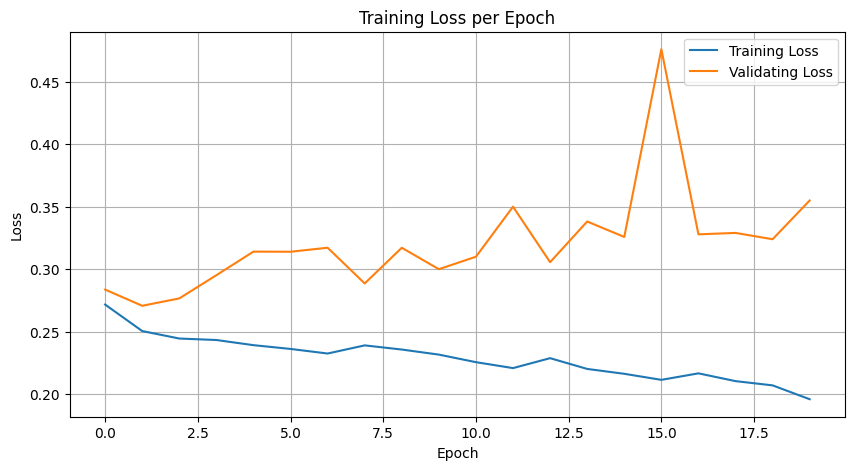

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validating Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('Training Loss.png')

In [1]:
plt.figure(figsize=(12, 8))

plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(val_dice_scores, label='Validation Dice Score')
plt.plot(val_iou_scores, label='Validation IoU Score')
plt.plot(val_precisions, label='Validation Precision')
plt.plot(val_recalls, label='Validation Recall')
plt.plot(val_f1_scores, label='Validation F1 Score')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation Metrics per Epoch')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('Validation Metrics.png')

NameError: name 'plt' is not defined